In [ ]:
####### FINAL CODE ########

In [ ]:
# STEP 0 — Environment, reproducibility, and HTTP session helpers
# Run this once per session (e.g., at the top of your notebook/script).

import os, platform, sys, time, random
import numpy as np
import pandas as pd
import requests

# 0.1 — Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# 0.2 — Robust HTTP session with retries/backoff (for ChEMBL/UniProt)
from requests.adapters import HTTPAdapter
try:
    from urllib3.util.retry import Retry
except Exception:
    # Some environments expose Retry at urllib3.util directly
    from urllib3.util import Retry

def build_session(user_agent="Sandra-Capstone/1.0"):
    s = requests.Session()
    s.headers.update({"User-Agent": user_agent, "Accept": "application/json"})
    retries = Retry(
        total=5, connect=5, read=5, backoff_factor=0.6,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=frozenset(["GET"])
    )
    adapter = HTTPAdapter(max_retries=retries)
    s.mount("https://", adapter)
    s.mount("http://", adapter)
    return s

SESSION = build_session()

def http_get_json(url, params=None, timeout=25):
    """GET JSON with retries via global SESSION."""
    r = SESSION.get(url, params=params, timeout=timeout)
    r.raise_for_status()
    return r.json()

# 0.3 — Small helpers reused later
def largest_fragment(smiles: str):
    """Return the largest SMILES fragment if salts/solvents present (SMILES with '.')."""
    if not isinstance(smiles, str) or smiles == "":
        return smiles
    parts = smiles.split(".")
    if len(parts) == 1:
        return smiles
    # choose fragment with most characters as a simple proxy for main component
    return max(parts, key=len)

def ensure_dir(path: str):
    """Create directory if it does not exist."""
    if path and not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

# 0.4 — Print versions (for reproducibility section in your report)
def print_versions():
    try:
        import sklearn
        skl = sklearn.__version__
    except Exception:
        skl = "not-installed"
    try:
        import rdkit
        rdk = rdkit.__version__
    except Exception:
        rdk = "not-installed"

    print("ENVIRONMENT")
    print("-----------")
    print(f"Python:          {sys.version.split()[0]}")
    print(f"Platform:        {platform.platform()}")
    print(f"pandas:          {pd.__version__}")
    print(f"numpy:           {np.__version__}")
    print(f"scikit-learn:    {skl}")
    print(f"rdkit:           {rdk}")
    print(f"Random seed:     {SEED}")

print_versions()


ENVIRONMENT
-----------
Python:          3.10.18
Platform:        macOS-13.1-arm64-arm-64bit
pandas:          2.3.1
numpy:           2.2.6
scikit-learn:    1.7.1
rdkit:           2024.03.6
Random seed:     42


In [38]:
# STEP 1 — Download & clean ChEMBL IC50 for COX1/COX2
# Output: step1_pairs_ic50.csv

import time
import pandas as pd
import numpy as np
import requests

# Reuse SESSION and helpers from Step 0:
# - SESSION
# - http_get_json
# - largest_fragment
# - ensure_dir

# 1.1 — Project parameters
CHEMBL_COX1 = "CHEMBL2095188"  # PTGS1 / COX-1 (human)
CHEMBL_COX2 = "CHEMBL2094253"  # PTGS2 / COX-2 (human)
STD_TYPE    = "IC50"
STD_UNITS   = "nM"
SAVE_PATH   = "."  # or "data" 

ensure_dir(SAVE_PATH)

# 1.2 — Paginated download of ChEMBL activities
def get_activities_for_target(target_id, max_pages=80, page_size=200, pause=0.08):
    base = "https://www.ebi.ac.uk/chembl/api/data/activity.json"
    rows = []
    for p in range(max_pages):
        params = {
            "target_chembl_id": target_id,
            "standard_type": STD_TYPE,
            "standard_units": STD_UNITS,
            "limit": page_size,
            "offset": p * page_size
        }
        try:
            data = http_get_json(base, params=params)
        except requests.exceptions.RequestException as e:
            print(f"Notice: failed page {p} for {target_id}: {e}")
            break
        items = data.get("activities", [])
        if not items:
            break
        rows.extend(items)
        time.sleep(pause)  # be polite to the API
    return pd.DataFrame(rows)

# 1.3 — Fetch canonical SMILES for a molecule if missing
def fetch_smiles_by_molid(molecule_chembl_id):
    url = f"https://www.ebi.ac.uk/chembl/api/data/molecule/{molecule_chembl_id}.json"
    try:
        j = http_get_json(url)
    except requests.exceptions.RequestException:
        return None
    return (j.get("molecule_structures") or {}).get("canonical_smiles", None)

# 1.4 — Basic cleaning
def clean_activities(df):
    """Keep required columns, filter to '=' relations, positive numeric IC50, and collapse duplicates."""
    needed = ["molecule_chembl_id", "target_chembl_id", "standard_value",
              "standard_relation", "canonical_smiles"]
    for c in needed:
        if c not in df.columns:
            df[c] = None

    df["standard_value"] = pd.to_numeric(df["standard_value"], errors="coerce")
    df = df[df["standard_relation"].fillna("=") == "="]
    df = df.dropna(subset=["standard_value"])
    df = df[df["standard_value"] > 0]

    # Collapse duplicates per molecule-target by taking median IC50
    df = (df.groupby(["molecule_chembl_id", "target_chembl_id"], as_index=False)
            .agg({"standard_value": "median", "canonical_smiles": "first"}))
    return df

# 1.5 — Download
print("Downloading activities from ChEMBL...")
raw1 = get_activities_for_target(CHEMBL_COX1)
raw2 = get_activities_for_target(CHEMBL_COX2)
print("Raw records:", len(raw1), len(raw2))

# 1.6 — Clean and label
df1 = clean_activities(raw1); df1["protein"] = "COX1"; df1["label"] = 0
df2 = clean_activities(raw2); df2["protein"] = "COX2"; df2["label"] = 1
pairs = pd.concat([df1, df2], ignore_index=True)

# 1.7 — Fill missing SMILES via molecule endpoint
missing_mask = pairs["canonical_smiles"].isna() | (pairs["canonical_smiles"] == "")
need_ids = pairs.loc[missing_mask, "molecule_chembl_id"].dropna().unique().tolist()
smiles_cache = {}
for mid in need_ids:
    smiles_cache[mid] = fetch_smiles_by_molid(mid)
    time.sleep(0.03)  # avoid hammering the API
pairs.loc[missing_mask, "canonical_smiles"] = pairs.loc[missing_mask, "molecule_chembl_id"].map(smiles_cache)

# 1.8 — Drop rows still missing SMILES and keep largest fragment
pairs = pairs.dropna(subset=["canonical_smiles"]).copy()
pairs["canonical_smiles"] = pairs["canonical_smiles"].map(largest_fragment)

# 1.9 — Compute pChEMBL from IC50 in nM: pChEMBL = -log10(IC50 [M]) = -log10(nM × 1e-9)
pairs["pchembl_value"] = -np.log10(pairs["standard_value"] * 1e-9)

# 1.10 — Final columns and save
cols = [
    "molecule_chembl_id", "target_chembl_id", "canonical_smiles",
    "protein", "label", "standard_value", "pchembl_value"
]
pairs = pairs[cols].drop_duplicates()

out_csv = os.path.join(SAVE_PATH, "step1_pairs_ic50.csv")
pairs.to_csv(out_csv, index=False)
print(f"Saved: {out_csv}")

# 1.11 — Small console summary
print("Summary")
print("-------")
print("Total pairs:", len(pairs))
print("Unique molecules:", pairs["molecule_chembl_id"].nunique())
print("By class:", pairs["protein"].value_counts().to_dict())
print(pairs.head(5))


Raw records: 639 191
Saved: ./step1_pairs_ic50.csv
Summary
-------
Total pairs: 580
Unique molecules: 580
By class: {'COX1': 449, 'COX2': 131}
  molecule_chembl_id target_chembl_id  \
0       CHEMBL102714    CHEMBL2095188   
1      CHEMBL1076156    CHEMBL2095188   
2      CHEMBL1081243    CHEMBL2095188   
3      CHEMBL1081244    CHEMBL2095188   
4      CHEMBL1081557    CHEMBL2095188   

                                    canonical_smiles protein  label  \
0     Cn1cc(C2=C(c3ccc(Cl)cc3Cl)C(=O)NC2=O)c2ccccc21    COX1      0   
1  CN1C(=O)/C(=C/c2ccc3c(c2)OCO3)N=C1NCC/N=C/c1cc...    COX1      0   
2             CN1C(=O)/C(=C/c2ccc3c(c2)OCO3)N=C1NCCN    COX1      0   
3  CN1C(=O)/C(=C/c2ccc3c(c2)OCO3)N=C1NCC/N=C/c1cc...    COX1      0   
4  CN1C(=O)/C(=C/c2ccc3c(c2)OCO3)N=C1NCC/N=C/c1cc...    COX1      0   

   standard_value  pchembl_value  
0            54.5       7.263603  
1         15000.0       4.823909  
2          1400.0       5.853872  
3          7000.0       5.154902  
4       

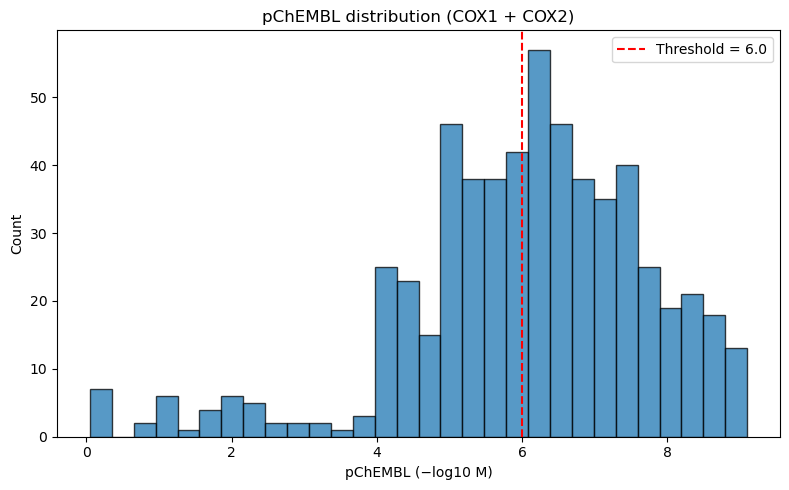

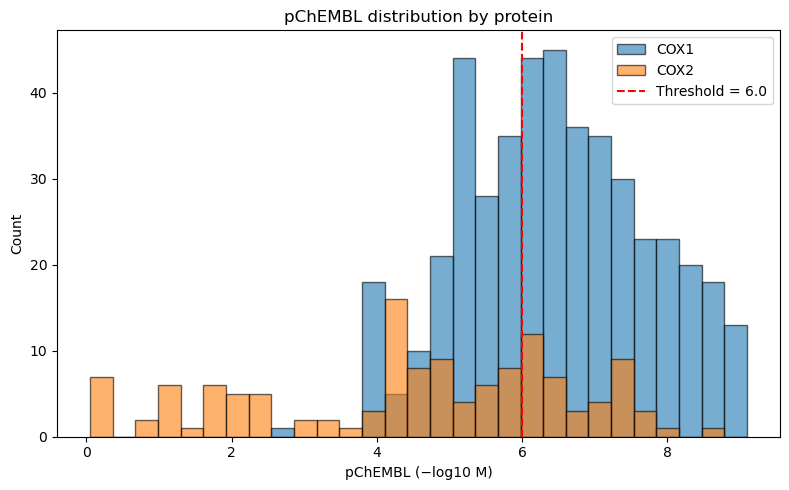

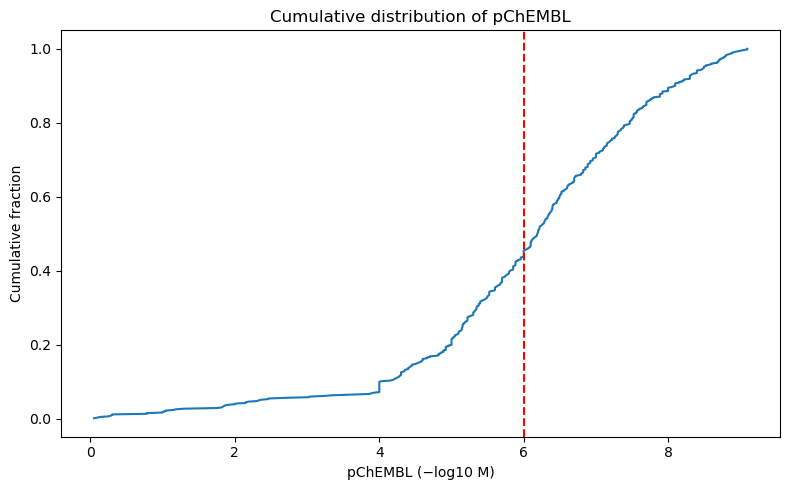

/var/folders/zw/dm091lnx7jx05gc6myjkzq8w0000gn/T/ipykernel_30312/762080947.py:65: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_protein, labels=labels, showfliers=False)


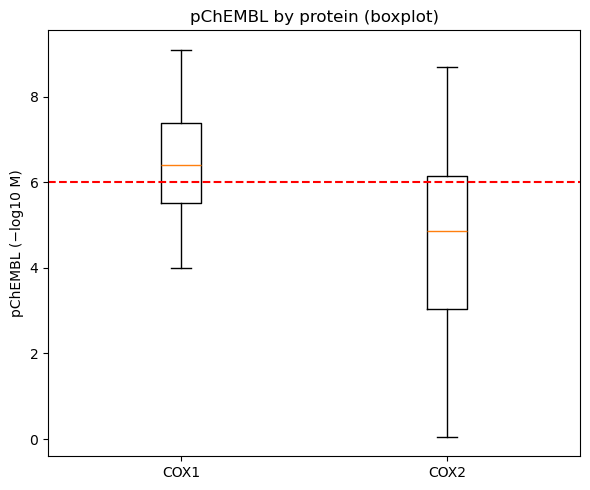

Activity threshold: 6.0

Class balance by protein (counts):
active     0    1
protein          
COX1     163  286
COX2      91   40


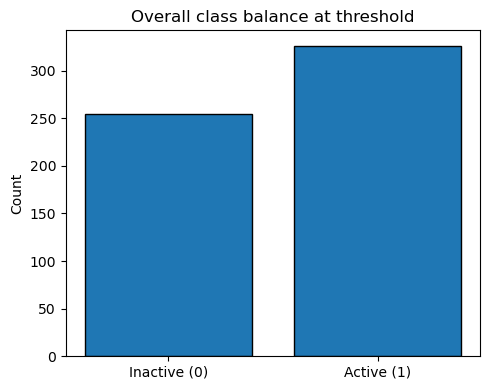


Saved: step2_pairs_thresholded.csv


In [43]:
## STEP 2 — Activity threshold & dataset preparation (matplotlib only, no seaborn)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

INPUT_CSV  = "step1_pairs_ic50.csv"       # <-- this is what Step 1 saved
OUTPUT_CSV = "step2_pairs_thresholded.csv"
THRESHOLD  = 6.0  # pChEMBL cutoff (~1 µM)

# 2.1 — Load Step 1 output
if not os.path.exists(INPUT_CSV):
    raise FileNotFoundError(f"Could not find {INPUT_CSV}. Make sure Step 1 ran successfully.")

df = pd.read_csv(INPUT_CSV)
if "pchembl_value" not in df.columns:
    raise ValueError("Expected 'pchembl_value' in the Step 1 CSV.")

# 2.2 — Overall pChEMBL histogram with threshold
plt.figure(figsize=(8,5))
plt.hist(df["pchembl_value"].dropna().values, bins=30, alpha=0.75, edgecolor="k")
plt.axvline(THRESHOLD, color="red", linestyle="--", label=f"Threshold = {THRESHOLD}")
plt.xlabel("pChEMBL (−log10 M)")
plt.ylabel("Count")
plt.title("pChEMBL distribution (COX1 + COX2)")
plt.legend()
plt.tight_layout()
plt.show()

# 2.3 — Overlaid histograms per protein (COX1 vs COX2)
vals1 = df[df["protein"]=="COX1"]["pchembl_value"].dropna().values
vals2 = df[df["protein"]=="COX2"]["pchembl_value"].dropna().values
bins = np.linspace(min(df["pchembl_value"]), max(df["pchembl_value"]), 30)

plt.figure(figsize=(8,5))
plt.hist(vals1, bins=bins, alpha=0.6, edgecolor="k", label="COX1")
plt.hist(vals2, bins=bins, alpha=0.6, edgecolor="k", label="COX2")
plt.axvline(THRESHOLD, color="red", linestyle="--", label=f"Threshold = {THRESHOLD}")
plt.xlabel("pChEMBL (−log10 M)")
plt.ylabel("Count")
plt.title("pChEMBL distribution by protein")
plt.legend()
plt.tight_layout()
plt.show()

# 2.4 — Cumulative distribution (overall)
sorted_vals = np.sort(df["pchembl_value"].dropna().values)
cum = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)

plt.figure(figsize=(8,5))
plt.plot(sorted_vals, cum)
plt.axvline(THRESHOLD, color="red", linestyle="--")
plt.xlabel("pChEMBL (−log10 M)")
plt.ylabel("Cumulative fraction")
plt.title("Cumulative distribution of pChEMBL")
plt.tight_layout()
plt.show()

# 2.5 — Boxplot by protein
data_by_protein = [vals1, vals2]
labels = ["COX1", "COX2"]

plt.figure(figsize=(6,5))
plt.boxplot(data_by_protein, labels=labels, showfliers=False)
plt.axhline(THRESHOLD, color="red", linestyle="--")
plt.ylabel("pChEMBL (−log10 M)")
plt.title("pChEMBL by protein (boxplot)")
plt.tight_layout()
plt.show()

# 2.6 — Create binary label using threshold
df["active"] = (df["pchembl_value"] >= THRESHOLD).astype(int)

# 2.7 — Class balance table (printed)
print("Activity threshold:", THRESHOLD)
print("\nClass balance by protein (counts):")
print(df.groupby(["protein", "active"]).size().unstack(fill_value=0))

# 2.8 — Simple class balance bar chart (overall)
counts = df["active"].value_counts().sort_index()  # 0 then 1
plt.figure(figsize=(5,4))
plt.bar(["Inactive (0)", "Active (1)"], [counts.get(0,0), counts.get(1,0)], edgecolor="k")
plt.ylabel("Count")
plt.title("Overall class balance at threshold")
plt.tight_layout()
plt.show()

# 2.9 — Save thresholded dataset for next steps
df.to_csv(OUTPUT_CSV, index=False)
print(f"\nSaved: {OUTPUT_CSV}")




In [44]:
# STEP 3 — UniProt sequences (human COX1/COX2)
# Output: protein_sequences.csv

import pandas as pd
import requests

# Reuse SESSION and http_get_json from Step 0.
# If you're running this in a new session, re-run Step 0 first.

UNIPROT = {
    "COX1": "P23219",  # PTGS1 (human)
    "COX2": "P35354",  # PTGS2 (human)
}

def fetch_uniprot_fasta(accession: str) -> str:
    url = f"https://rest.uniprot.org/uniprotkb/{accession}.fasta"
    r = SESSION.get(url, timeout=30)
    r.raise_for_status()
    lines = r.text.strip().split("\n")
    return "".join(lines[1:])  # skip header

rows = []
for prot, acc in UNIPROT.items():
    seq = fetch_uniprot_fasta(acc)
    rows.append({"protein": prot, "sequence": seq})
    print(f"{prot}: {len(seq)} aa")

df_seq = pd.DataFrame(rows)
df_seq.to_csv("protein_sequences.csv", index=False)
print("Saved: protein_sequences.csv")
print(df_seq)


COX1: 599 aa
COX2: 604 aa
Saved: protein_sequences.csv
  protein                                           sequence
0    COX1  MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...
1    COX2  MLARALLLCAVLALSHTANPCCSHPCQNRGVCMSVGFDQYKCDCTR...


In [45]:
# STEP 4 — Protein features (Amino Acid Composition)
# Output: step5_protein_features.csv

import numpy as np
import pandas as pd

AMINO_ACIDS = list("ACDEFGHIKLMNPQRSTVWY")

def compute_aac(seq: str):
    s = str(seq).upper()
    n = len(s)
    return [s.count(a)/n for a in AMINO_ACIDS]

seq_df = pd.read_csv("protein_sequences.csv")
rows = []
for prot, seq in zip(seq_df["protein"], seq_df["sequence"]):
    rows.append((prot, *compute_aac(seq)))

aac_df = pd.DataFrame(rows, columns=["protein"] + [f"AAC_{aa}" for aa in AMINO_ACIDS])
aac_df.to_csv("step5_protein_features.csv", index=False)
print("Saved: step5_protein_features.csv")
print(aac_df)


Saved: step5_protein_features.csv
  protein     AAC_A     AAC_C     AAC_D     AAC_E     AAC_F     AAC_G  \
0    COX1  0.041736  0.021703  0.040067  0.060100  0.065109  0.075125   
1    COX2  0.051325  0.021523  0.043046  0.059603  0.062914  0.061258   

      AAC_H     AAC_I     AAC_K  ...     AAC_M     AAC_N     AAC_P     AAC_Q  \
0  0.030050  0.041736  0.041736  ...  0.030050  0.031720  0.076795  0.045075   
1  0.031457  0.056291  0.056291  ...  0.024834  0.048013  0.066225  0.051325   

      AAC_R     AAC_S     AAC_T     AAC_V     AAC_W     AAC_Y  
0  0.055092  0.055092  0.050083  0.053422  0.016694  0.045075  
1  0.044702  0.057947  0.056291  0.057947  0.009934  0.044702  

[2 rows x 21 columns]


In [46]:
# STEP 5 — Ligand features from SMILES (Morgan fingerprints)
# Output: step4_ligand_features.csv

import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit import DataStructs, RDLogger
RDLogger.DisableLog("rdApp.*")

pairs = pd.read_csv("step2_pairs_thresholded.csv")  # from Step 2
uniq = pairs[["molecule_chembl_id", "canonical_smiles"]].drop_duplicates().reset_index(drop=True)

gen = GetMorganGenerator(radius=2, fpSize=1024)

rows, bad = [], 0
for mid, smi in zip(uniq["molecule_chembl_id"], uniq["canonical_smiles"]):
    if not isinstance(smi, str) or smi == "":
        bad += 1
        continue
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        bad += 1
        continue
    bv = gen.GetFingerprint(mol)  # ExplicitBitVect
    arr = np.zeros((1024,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(bv, arr)
    rows.append((mid, arr))

if bad:
    print(f"Warning: {bad} molecules skipped due to invalid/empty SMILES.")

if not rows:
    raise RuntimeError("No valid Morgan fingerprints could be generated.")

mol_ids = [r[0] for r in rows]
fp_mat = np.vstack([r[1] for r in rows])
fp_df = pd.DataFrame(fp_mat, columns=[f"fp_{i}" for i in range(fp_mat.shape[1])])
fp_df.insert(0, "molecule_chembl_id", mol_ids)

fp_df.to_csv("step4_ligand_features.csv", index=False)
print("Saved: step4_ligand_features.csv  shape:", fp_df.shape)


Saved: step4_ligand_features.csv  shape: (580, 1025)


In [47]:
# STEP 6 — Build the PCM dataset (merge ligand + protein features)
# Inputs:
#   step2_pairs_thresholded.csv   (from Step 2)
#   step4_ligand_features.csv     (from Step 5)
#   step5_protein_features.csv    (from Step 4)
# Output:
#   step6_pcm_dataset.csv

import os
import numpy as np
import pandas as pd

pairs = pd.read_csv("step2_pairs_thresholded.csv")
lig   = pd.read_csv("step4_ligand_features.csv")
prot  = pd.read_csv("step5_protein_features.csv")

# Sanity checks
req_pairs = {"molecule_chembl_id","protein","canonical_smiles","pchembl_value","active"}
if not req_pairs.issubset(pairs.columns):
    missing = req_pairs - set(pairs.columns)
    raise ValueError(f"Step 6: Missing columns in step2_pairs_thresholded.csv: {missing}")

# Keep only needed columns and deduplicate
pairs_small = pairs[["molecule_chembl_id","protein","canonical_smiles","pchembl_value","active"]].drop_duplicates()

# Merge ligand features (on molecule_chembl_id)
merged = pairs_small.merge(lig, on="molecule_chembl_id", how="inner")

# Merge protein features (on protein)
merged = merged.merge(prot, on="protein", how="inner")

# Convenience: keep both 'active' and 'label' (same values) for downstream code
merged["label"] = merged["active"].astype(int)

# Save final PCM table
merged.to_csv("step6_pcm_dataset.csv", index=False)

print("Saved: step6_pcm_dataset.csv")
print("Shape:", merged.shape)
print(merged.head(3))


Saved: step6_pcm_dataset.csv
Shape: (580, 1050)
  molecule_chembl_id protein  \
0       CHEMBL102714    COX1   
1      CHEMBL1076156    COX1   
2      CHEMBL1081243    COX1   

                                    canonical_smiles  pchembl_value  active  \
0     Cn1cc(C2=C(c3ccc(Cl)cc3Cl)C(=O)NC2=O)c2ccccc21       7.263603       1   
1  CN1C(=O)/C(=C/c2ccc3c(c2)OCO3)N=C1NCC/N=C/c1cc...       4.823909       0   
2             CN1C(=O)/C(=C/c2ccc3c(c2)OCO3)N=C1NCCN       5.853872       0   

   fp_0  fp_1  fp_2  fp_3  fp_4  ...    AAC_N     AAC_P     AAC_Q     AAC_R  \
0     0     0     0     0     0  ...  0.03172  0.076795  0.045075  0.055092   
1     0     0     0     0     0  ...  0.03172  0.076795  0.045075  0.055092   
2     0     0     0     0     0  ...  0.03172  0.076795  0.045075  0.055092   

      AAC_S     AAC_T     AAC_V     AAC_W     AAC_Y  label  
0  0.055092  0.050083  0.053422  0.016694  0.045075      1  
1  0.055092  0.050083  0.053422  0.016694  0.045075      0  
2  0.0

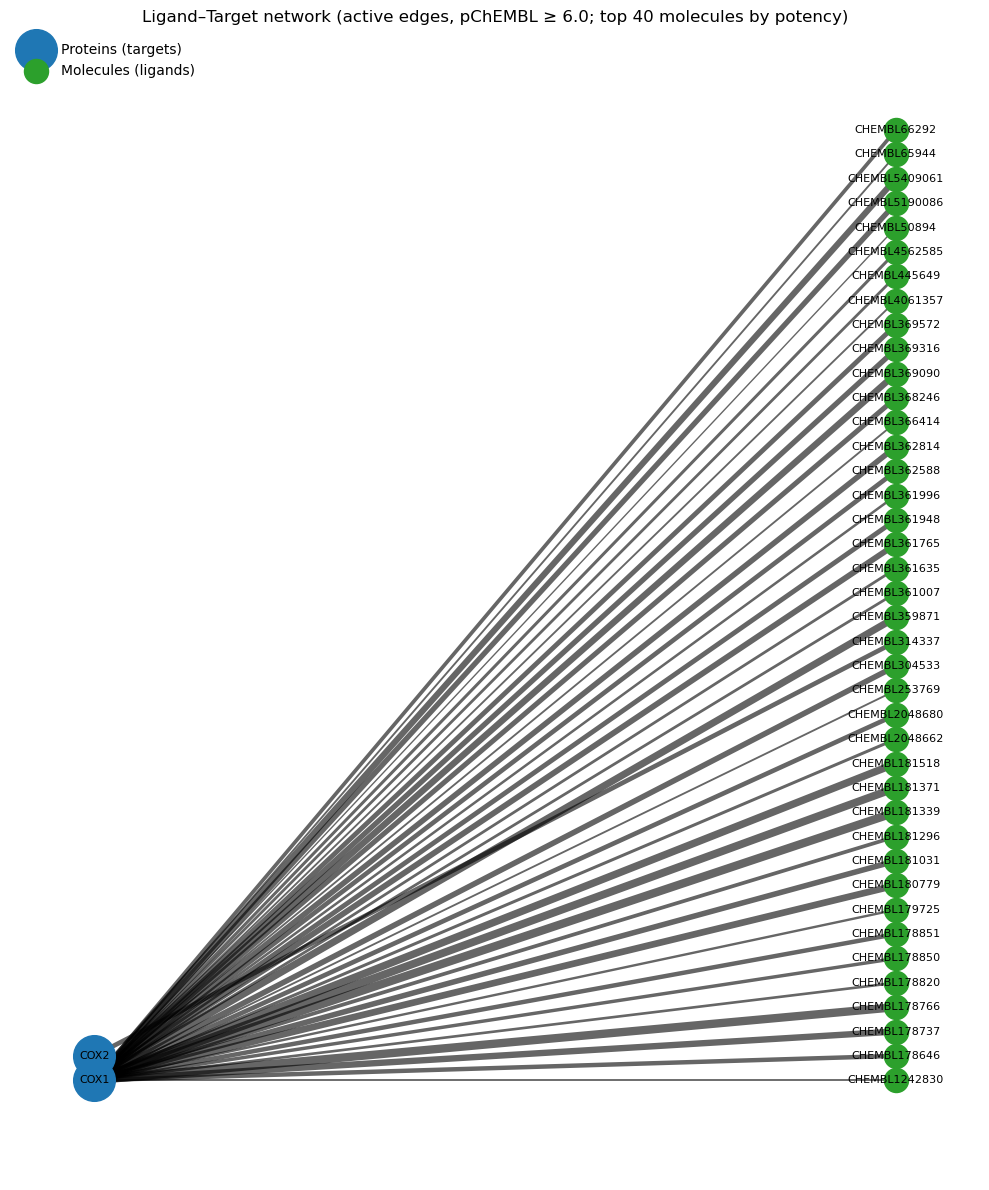

Network summary → Proteins: 2, Molecules: 40, Active edges: 40


In [ ]:
# STEP 6.5 — Ligand–Target Network visualization (EDA, poster-ready)
# Shows an inline bipartite graph of ACTIVE interactions (pChEMBL ≥ 6.0)

import sys, subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure networkx is available (installs into the active kernel if missing)
try:
    import networkx as nx
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "networkx"])
    import networkx as nx

THRESH = 6.0
TOP_N = 40  # limit to top-N molecules by potency to keep the graph readable

# 1) Load the PCM dataset from Step 6
df = pd.read_csv("step6_pcm_dataset.csv")

# 2) Keep only ACTIVE rows (label==1 is already based on pChEMBL ≥ 6.0 in Step 6)
if "label" not in df.columns:
    # Fallback if label was not created for some reason
    if "pchembl_value" not in df.columns:
        raise ValueError("step6_pcm_dataset.csv missing both 'label' and 'pchembl_value'.")
    df["label"] = (df["pchembl_value"] >= THRESH).astype(int)

active = df[df["label"] == 1].copy()

# 3) To ensure clarity, select the strongest TOP_N active molecules by pChEMBL
if "pchembl_value" in active.columns:
    active = active.sort_values("pchembl_value", ascending=False).head(TOP_N)
else:
    # If pChEMBL wasn't carried through (should be), just take a head sample
    active = active.head(TOP_N)

# 4) Build a bipartite graph: left = proteins (COX1/COX2), right = molecules
G = nx.Graph()

# Add protein nodes (type="protein")
proteins = sorted(active["protein"].dropna().unique().tolist())
for prot in proteins:
    G.add_node(prot, kind="protein")

# Add molecule nodes (type="molecule") and edges with potency as weight
for _, row in active.iterrows():
    mid = str(row["molecule_chembl_id"])
    prot = str(row["protein"])
    potency = float(row.get("pchembl_value", THRESH))  # safe fallback
    G.add_node(mid, kind="molecule")
    G.add_edge(mid, prot, weight=potency)

# 5) Layout: two columns (proteins left, molecules right), tidy vertical spacing
pos = {}
prot_nodes = [n for n, d in G.nodes(data=True) if d.get("kind") == "protein"]
mol_nodes  = [n for n, d in G.nodes(data=True) if d.get("kind") == "molecule"]

# Place proteins at x=0, molecules at x=1, with ordered y positions
pos.update({n: (0, i) for i, n in enumerate(sorted(prot_nodes))})
pos.update({n: (1, i) for i, n in enumerate(sorted(mol_nodes))})

# 6) Edge widths scaled by potency (pChEMBL); shift/scale to a sane visual range
weights = [G[u][v]["weight"] for u, v in G.edges()]
if len(weights) == 0:
    print("No active edges to display at the chosen threshold.")
else:
    w_min, w_max = min(weights), max(weights)
    # Normalize to [1, 6] for visibility
    def scale_w(w, wmin=w_min, wmax=w_max):
        if wmax == wmin:
            return 3.0
        return 1.0 + 5.0 * (w - wmin) / (wmax - wmin)
    edge_widths = [scale_w(G[u][v]["weight"]) for u, v in G.edges()]

    # 7) Draw network
    plt.figure(figsize=(10, max(6, len(mol_nodes)*0.25 + 2)))
    nx.draw_networkx_nodes(G, pos, nodelist=prot_nodes, node_color="#1f77b4",
                           node_size=900, label="Proteins (targets)")
    nx.draw_networkx_nodes(G, pos, nodelist=mol_nodes, node_color="#2ca02c",
                           node_size=300, label="Molecules (ligands)")
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.axis("off")
    title_note = f"Ligand–Target network (active edges, pChEMBL ≥ {THRESH}; top {TOP_N} molecules by potency)"
    plt.title(title_note)
    plt.legend(scatterpoints=1, frameon=False, loc="upper left")
    plt.tight_layout()
    plt.show()

# Optional: quick summary counts for your report/poster text
n_mols = len(mol_nodes)
n_prot = len(prot_nodes)
n_edges = G.number_of_edges()
print(f"Network summary → Proteins: {n_prot}, Molecules: {n_mols}, Active edges: {n_edges}")


Loaded existing train/test indices.
Train shape: (464, 1044), Test shape: (116, 1044)


/opt/anaconda3/envs/capstone-rdkit/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/capstone-rdkit/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
  File "/opt/anaconda3/envs/capstone-rdkit/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/opt/anaconda3/envs/capstone-rdkit/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/opt/anaconda3/envs/capstone-rdkit/lib/python3.10/inspect.py", line 3186, in bind
    return self._bind(args, kwargs)
  File "/opt/anaconda3/envs/capstone-rdkit/lib/python3.10/inspect.py", line 3175, in _bind
 


Model comparison (test-set metrics):
          model                                        best_params    auc  \
0  RandomForest  {'rf__base_estimator__max_depth': None, 'rf__b...  0.927   
1           KNN  {'knn__base_estimator__n_neighbors': 3, 'knn__...  0.881   
2        LogReg                     {'lr__base_estimator__C': 0.1}  0.879   

      ap    thr    acc   prec    rec     f1  
0  0.948  0.385  0.853  0.848  0.889  0.868  
1  0.846  0.667  0.836  0.844  0.857  0.850  
2  0.862  0.285  0.819  0.818  0.857  0.837  


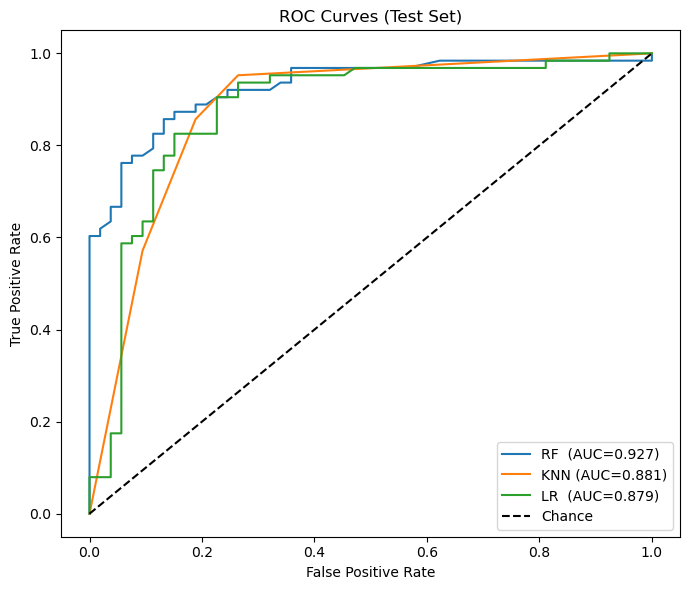

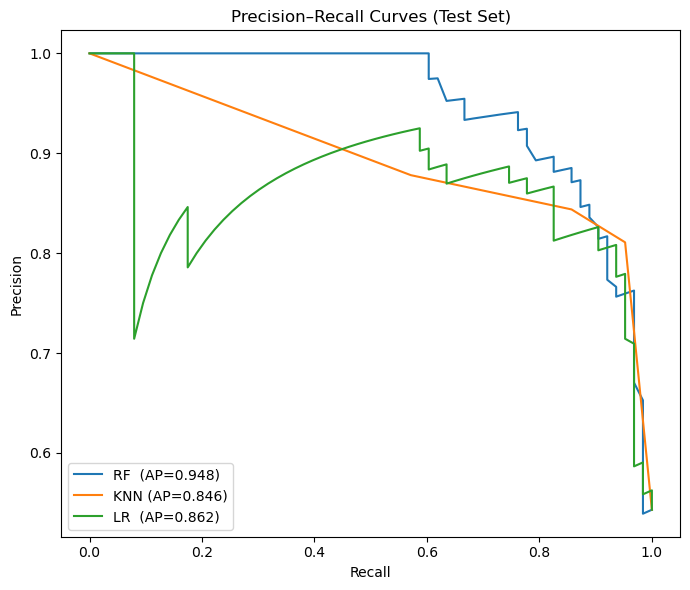

In [48]:
# STEP 7 — Model selection with group-aware split (RF, KNN, Logistic Regression)
# Outputs:
#   indices_train.csv, indices_test.csv
#   step7_models_metrics.csv
# Plots (inline):
#   ROC curves (all models)
#   Precision–Recall curves (all models)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score, make_scorer
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, clone

# 7.1 — Load PCM dataset
df = pd.read_csv("step6_pcm_dataset.csv")

fp_cols  = [c for c in df.columns if c.startswith("fp_")]
aac_cols = [c for c in df.columns if c.startswith("AAC_")]
feature_cols = fp_cols + aac_cols
if not feature_cols:
    raise ValueError("No features found (expected columns starting with 'fp_' and 'AAC_').")

X = df[feature_cols].astype(np.float32).values
y = df["label"].astype(int).values  # same as 'active'
groups = df["molecule_chembl_id"].astype(str).values

# 7.2 — Reproducible molecule-wise holdout split (save indices)
try:
    tr_idx = pd.read_csv("indices_train.csv", header=None)[0].values
    te_idx = pd.read_csv("indices_test.csv",  header=None)[0].values
    print("Loaded existing train/test indices.")
except Exception:
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, te_idx = next(gss.split(X, y, groups))
    pd.Series(tr_idx).to_csv("indices_train.csv", index=False, header=False)
    pd.Series(te_idx).to_csv("indices_test.csv",  index=False, header=False)
    print("Saved new train/test indices.")

Xtr, Xte = X[tr_idx], X[te_idx]
ytr, yte = y[tr_idx], y[te_idx]
groups_tr = groups[tr_idx]

print(f"Train shape: {Xtr.shape}, Test shape: {Xte.shape}")

# 7.3 — Manual train-only undersampling (no imblearn)
def undersample_indices(y_vec, random_state=42):
    rng = np.random.default_rng(random_state)
    classes, counts = np.unique(y_vec, return_counts=True)
    if len(classes) != 2:
        return np.arange(len(y_vec))
    c0, c1 = classes
    n0, n1 = counts
    n_target = min(n0, n1)
    idx0 = np.where(y_vec == c0)[0]
    idx1 = np.where(y_vec == c1)[0]
    sel0 = rng.choice(idx0, size=n_target, replace=False)
    sel1 = rng.choice(idx1, size=n_target, replace=False)
    return np.sort(np.concatenate([sel0, sel1]))

class DownsampledEstimator(BaseEstimator, ClassifierMixin):
    """Wrap an estimator; during fit(), downsample the training data only."""
    def __init__(self, base_estimator, random_state=42):
        self.base_estimator = base_estimator
        self.random_state = random_state
    def fit(self, X_fit, y_fit):
        sel = undersample_indices(y_fit, self.random_state)
        self.est_ = clone(self.base_estimator)
        self.est_.fit(X_fit[sel], y_fit[sel])
        return self
    def predict_proba(self, X_eval):
        return self.est_.predict_proba(X_eval)
    def predict(self, X_eval):
        return self.est_.predict(X_eval)

# 7.4 — GroupKFold CV on TRAIN ONLY
gkf = GroupKFold(n_splits=5)
ap_scorer  = make_scorer(average_precision_score, needs_proba=True)
roc_scorer = make_scorer(roc_auc_score,         needs_proba=True)

def choose_thr_from_train(clf, X_train, y_train):
    """Pick the probability threshold that maximizes F1 on the TRAIN set."""
    prob = clf.predict_proba(X_train)[:, 1]
    P, R, T = precision_recall_curve(y_train, prob)
    if len(T) == 0:
        return 0.5
    F1 = (2 * P[:-1] * R[:-1]) / np.clip(P[:-1] + R[:-1], 1e-9, None)
    return float(T[int(np.nanargmax(F1))])

def run_grid(name, pipe, param_grid):
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=gkf.split(Xtr, ytr, groups_tr),
        scoring={'average_precision': ap_scorer, 'roc_auc': roc_scorer},
        refit='average_precision',
        n_jobs=-1,
        verbose=0
    )
    gs.fit(Xtr, ytr)
    prob_te = gs.predict_proba(Xte)[:, 1]
    thr = choose_thr_from_train(gs, Xtr, ytr)
    y_pred = (prob_te >= thr).astype(int)

    res = dict(
        model=name,
        best_params=str(gs.best_params_),
        auc=round(roc_auc_score(yte, prob_te), 3),
        ap =round(average_precision_score(yte, prob_te), 3),
        thr=round(thr, 3),
        acc=round(accuracy_score(yte, y_pred), 3),
        prec=round(precision_score(yte, y_pred, zero_division=0), 3),
        rec =round(recall_score(yte, y_pred, zero_division=0), 3),
        f1  =round(f1_score(yte, y_pred, zero_division=0), 3),
    )

    fpr, tpr, _ = roc_curve(yte, prob_te)
    prec_curve, rec_curve, _ = precision_recall_curve(yte, prob_te)
    return res, (fpr, tpr), (rec_curve, prec_curve), gs

# 7.5 — Define models and grids (kept compact but meaningful)
rf_base  = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_pipe  = Pipeline([("rf", DownsampledEstimator(rf_base, random_state=42))])
rf_grid  = {
    "rf__base_estimator__n_estimators":   [200, 400],
    "rf__base_estimator__max_depth":      [None, 20],
    "rf__base_estimator__min_samples_leaf":[1, 2],
}

knn_base = KNeighborsClassifier()
knn_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("knn", DownsampledEstimator(knn_base, random_state=42)),
])
knn_grid = {
    "knn__base_estimator__n_neighbors": [3, 5, 9],
    "knn__base_estimator__weights":     ["uniform", "distance"],
}

lr_base  = LogisticRegression(max_iter=2000, solver="lbfgs")
lr_pipe  = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("lr", DownsampledEstimator(lr_base, random_state=42)),
])
lr_grid = {
    "lr__base_estimator__C": [0.1, 1, 3],
}

# 7.6 — Run model selection and evaluation
res_rf,  roc_rf,  pr_rf,  _ = run_grid("RandomForest", rf_pipe, rf_grid)
res_knn, roc_knn, pr_knn, _ = run_grid("KNN",          knn_pipe, knn_grid)
res_lr,  roc_lr,  pr_lr,  _ = run_grid("LogReg",       lr_pipe,  lr_grid)

# 7.7 — Summarize & save metrics table
metrics_df = pd.DataFrame([res_rf, res_knn, res_lr])
metrics_df.to_csv("step7_models_metrics.csv", index=False)
print("\nModel comparison (test-set metrics):")
print(metrics_df)

# 7.8 — ROC curves (inline)
plt.figure(figsize=(7,6))
plt.plot(roc_rf[0],  roc_rf[1],  label=f"RF  (AUC={res_rf['auc']})")
plt.plot(roc_knn[0], roc_knn[1], label=f"KNN (AUC={res_knn['auc']})")
plt.plot(roc_lr[0],  roc_lr[1],  label=f"LR  (AUC={res_lr['auc']})")
plt.plot([0,1], [0,1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test Set)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# 7.9 — Precision–Recall curves (inline)
plt.figure(figsize=(7,6))
plt.plot(pr_rf[0],  pr_rf[1],  label=f"RF  (AP={res_rf['ap']})")
plt.plot(pr_knn[0], pr_knn[1], label=f"KNN (AP={res_knn['ap']})")
plt.plot(pr_lr[0],  pr_lr[1],  label=f"LR  (AP={res_lr['ap']})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Test Set)")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


Resolving Paracetamol in ChEMBL…
Paracetamol ChEMBL ID: CHEMBL3544802
Paracetamol SMILES: CC(=O)Nc1ccc(OS(=O)(=O)O)cc1

Paracetamol — Predicted probability of activity:
  protein  P_active
0    COX1    0.4700
1    COX2    0.3075


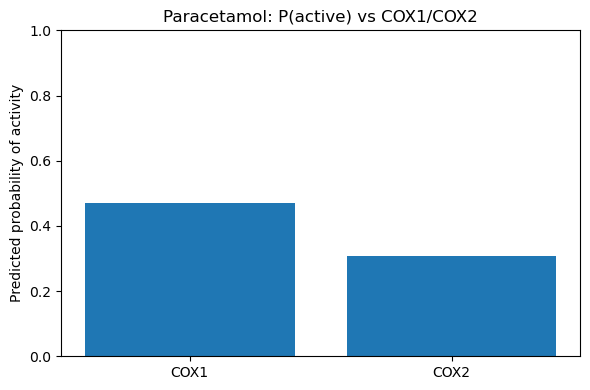

In [50]:
# STEP 8 — Paracetamol case study (ChEMBL lookup + model prediction vs COX1/COX2)
# Inputs:
#   step5_protein_features.csv  (AAC protein features from Step 4)
#   step6_pcm_dataset.csv       (PCM dataset from Step 6)
#   indices_train.csv/.test.csv (from Step 7; created if missing)
# What it does:
#   - Find Paracetamol in ChEMBL (via /search), get canonical SMILES
#   - Build Morgan 1024-bit fingerprint
#   - Pair with COX1/COX2 AAC features to create 2 PCM rows
#   - Train RF on TRAIN ONLY (reusing saved indices) and predict P(active) for those 2 rows
#   - Show a table and an inline bar chart

import os
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit import DataStructs, RDLogger
RDLogger.DisableLog("rdApp.*")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit

# ---------- 1) Robust helpers to talk to ChEMBL (professor-style /search) ----------
SESSION = requests.Session()
SESSION.headers.update({"User-Agent": "Sandra-Capstone/1.0", "Accept": "application/json"})

def get_chembl_id(query_name: str, resource_type: str = "molecule", limit=5):
    """
    Use ChEMBL /search to resolve a molecule or target ID.
    For targets, ChEMBL doesn't always filter by organism in /search; we prefer human by name where possible.
    """
    assert resource_type in ("molecule", "target")
    url = f"https://www.ebi.ac.uk/chembl/api/data/{resource_type}/search"
    params = {"q": query_name, "limit": limit, "format": "json"}
    r = SESSION.get(url, params=params, timeout=30)
    r.raise_for_status()
    data = r.json()
    results_key = "molecules" if resource_type == "molecule" else "targets"
    id_key = "molecule_chembl_id" if resource_type == "molecule" else "target_chembl_id"
    results = data.get(results_key, [])
    if not results:
        return None
    # Try to prefer exact-ish name match
    ql = query_name.lower()
    for rec in results:
        name = (rec.get("pref_name") or "").lower()
        if ql in name or name in ql:
            return rec.get(id_key)
    # Fallback: first hit
    return results[0].get(id_key)

def get_canonical_smiles_from_id(molecule_chembl_id: str) -> str:
    url = f"https://www.ebi.ac.uk/chembl/api/data/molecule/{molecule_chembl_id}.json"
    r = SESSION.get(url, timeout=30)
    r.raise_for_status()
    j = r.json()
    return (j.get("molecule_structures") or {}).get("canonical_smiles", "") or ""

# ---------- 2) Resolve Paracetamol and build Morgan fingerprint ----------
print("Resolving Paracetamol in ChEMBL…")
drug_id = get_chembl_id("Paracetamol", "molecule")
if not drug_id:
    print("Paracetamol not found, trying synonym: Acetaminophen")
    drug_id = get_chembl_id("Acetaminophen", "molecule")
if not drug_id:
    raise RuntimeError("Could not resolve Paracetamol/Acetaminophen ChEMBL ID via /search.")

print("Paracetamol ChEMBL ID:", drug_id)
smiles = get_canonical_smiles_from_id(drug_id)
if not smiles:
    raise RuntimeError("Could not fetch canonical SMILES for Paracetamol from ChEMBL.")
print("Paracetamol SMILES:", smiles)

gen = GetMorganGenerator(radius=2, fpSize=1024)
mol = Chem.MolFromSmiles(smiles)
if mol is None:
    raise ValueError("RDKit could not parse the Paracetamol SMILES.")
bv = gen.GetFingerprint(mol)
fp_arr = np.zeros((1024,), dtype=np.int8)
DataStructs.ConvertToNumpyArray(bv, fp_arr)

# ---------- 3) Build two PCM rows using your AAC features ----------
prot = pd.read_csv("step5_protein_features.csv")  # from Step 4
if not set(["COX1", "COX2"]).issubset(set(prot["protein"])):
    raise ValueError("step5_protein_features.csv must contain COX1 and COX2 rows.")
aac_cols = [c for c in prot.columns if c.startswith("AAC_")]

def row_for(protein_name: str):
    row = {"protein": protein_name}
    for i in range(1024):
        row[f"fp_{i}"] = int(fp_arr[i])
    row.update(prot.loc[prot["protein"] == protein_name, aac_cols].iloc[0].to_dict())
    return row

para_pcm = pd.DataFrame([row_for("COX1"), row_for("COX2")])

# ---------- 4) Align columns with the training schema & train RF on TRAIN only ----------
pcm_all = pd.read_csv("step6_pcm_dataset.csv")  # from Step 6
fp_cols  = [c for c in pcm_all.columns if c.startswith("fp_")]
aac_cols = [c for c in pcm_all.columns if c.startswith("AAC_")]
feature_cols = fp_cols + aac_cols

missing = [c for c in feature_cols if c not in para_pcm.columns]
if missing:
    raise ValueError(f"Paracetamol rows are missing expected feature columns (first few): {missing[:8]}")

X_par   = para_pcm[feature_cols].astype(np.float32).values
labels  = para_pcm["protein"].values

# Reuse saved train indices from Step 7 (create them if missing for robustness)
if os.path.exists("indices_train.csv"):
    tr_idx = pd.read_csv("indices_train.csv", header=None)[0].values
else:
    print("indices_train.csv not found; creating a new group split like Step 7.")
    groups_all = pcm_all["molecule_chembl_id"].astype(str).values
    y_all      = pcm_all["label"].astype(int).values
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, _ = next(gss.split(pcm_all[feature_cols].values, y_all, groups_all))
    pd.Series(tr_idx).to_csv("indices_train.csv", index=False, header=False)

X_train = pcm_all[feature_cols].astype(np.float32).iloc[tr_idx].values
y_train = pcm_all["label"].astype(int).iloc[tr_idx].values

rf = RandomForestClassifier(
    n_estimators=400, max_depth=None, min_samples_leaf=1,
    class_weight="balanced", random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)

probs = rf.predict_proba(X_par)[:, 1]

# ---------- 5) Show table and bar chart ----------
out = pd.DataFrame({"protein": labels, "P_active": probs})
print("\nParacetamol — Predicted probability of activity:")
print(out)

plt.figure(figsize=(6,4))
plt.bar(out["protein"], out["P_active"])
plt.ylim(0, 1)
plt.ylabel("Predicted probability of activity")
plt.title("Paracetamol: P(active) vs COX1/COX2")
plt.tight_layout()
plt.show()

# Optional: quick experimental context using professor-style interactions (not required for prediction)
def get_interactions(molecule_chembl_id: str, target_chembl_id: str, limit=1000):
    url = "https://www.ebi.ac.uk/chembl/api/data/activity"
    params = {"molecule_chembl_id": molecule_chembl_id, "target_chembl_id": target_chembl_id,
              "limit": limit, "format": "json"}
    r = SESSION.get(url, params=params, timeout=30)
    r.raise_for_status()
    return r.json().get("activities", [])

# If you want to print a tiny summary of any experimental records (optional):
# cox1_id = get_chembl_id("Prostaglandin G/H synthase 1", "target") or get_chembl_id("PTGS1", "target")
# cox2_id = get_chembl_id("Prostaglandin G/H synthase 2", "target") or get_chembl_id("PTGS2", "target")
# acts1 = get_interactions(drug_id, cox1_id) if cox1_id else []
# acts2 = get_interactions(drug_id, cox2_id) if cox2_id else []
# print(f"\nExperimental records found — COX1: {len(acts1)}  COX2: {len(acts2)}")




Similarity baseline results:
  protein most_similar_molecule  similarity  label_of_most_similar
0    COX1         CHEMBL3747661    0.264151                      1
1    COX2              CHEMBL25    0.282051                      0


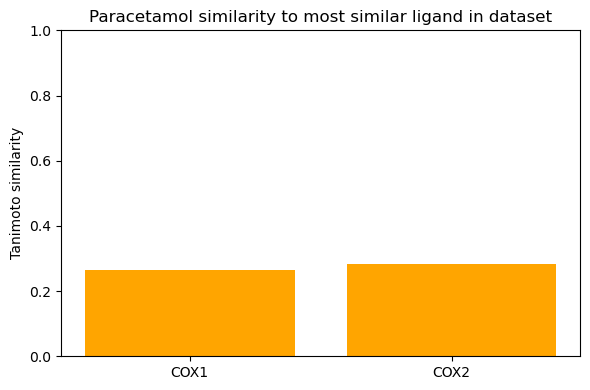

In [51]:
# STEP 9 — Similarity baseline for Paracetamol vs COX1/COX2

from rdkit import DataStructs

# Use same Paracetamol fingerprint from Step 8 (fp_arr)
para_fp_bv = gen.GetFingerprint(mol)  # Already generated in Step 8

pcm_all = pd.read_csv("step6_pcm_dataset.csv")

fp_cols  = [c for c in pcm_all.columns if c.startswith("fp_")]
aac_cols = [c for c in pcm_all.columns if c.startswith("AAC_")]

results_baseline = []

for prot in ["COX1", "COX2"]:
    subset = pcm_all[pcm_all["protein"] == prot].copy()
    
    # Convert dataset fingerprints to RDKit bitvectors for similarity calc
    fps_dataset = []
    for _, row in subset.iterrows():
        arr = row[fp_cols].astype(int).tolist()
        bv = DataStructs.CreateFromBitString("".join(map(str, arr)))
        fps_dataset.append(bv)
    
    # Compute similarity with Paracetamol
    sims = [DataStructs.TanimotoSimilarity(para_fp_bv, fp) for fp in fps_dataset]
    subset["similarity"] = sims
    
    # Find most similar ligand
    idx_max = subset["similarity"].idxmax()
    top_sim = subset.loc[idx_max]
    
    results_baseline.append({
        "protein": prot,
        "most_similar_molecule": top_sim["molecule_chembl_id"],
        "similarity": top_sim["similarity"],
        "label_of_most_similar": top_sim["label"]
    })

baseline_df = pd.DataFrame(results_baseline)

print("\nSimilarity baseline results:")
print(baseline_df)

# Optional visualization
plt.figure(figsize=(6,4))
plt.bar(baseline_df["protein"], baseline_df["similarity"], color="orange")
plt.ylabel("Tanimoto similarity")
plt.title("Paracetamol similarity to most similar ligand in dataset")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


Loaded Step 7 train/test indices.
Train: (464, 1044), Test: (116, 1044)

Top 20 features by permutation importance (TEST set):
    feature  importance_mean  importance_std
525  fp_525         0.008621        0.000000
285  fp_285         0.008621        0.000000
218  fp_218         0.008621        0.000000
171  fp_171         0.008621        0.000000
501  fp_501         0.008621        0.000000
378  fp_378         0.006897        0.003448
128  fp_128         0.005172        0.004223
511  fp_511         0.004023        0.006190
314  fp_314         0.004023        0.004301
633  fp_633         0.003448        0.004223
352  fp_352         0.002874        0.006800
428  fp_428         0.002874        0.005140
43    fp_43         0.002874        0.005140
491  fp_491         0.002874        0.004064
562  fp_562         0.002299        0.008005
787  fp_787         0.002299        0.003812
191  fp_191         0.002299        0.003812
119  fp_119         0.002299        0.005861
792  fp_792       

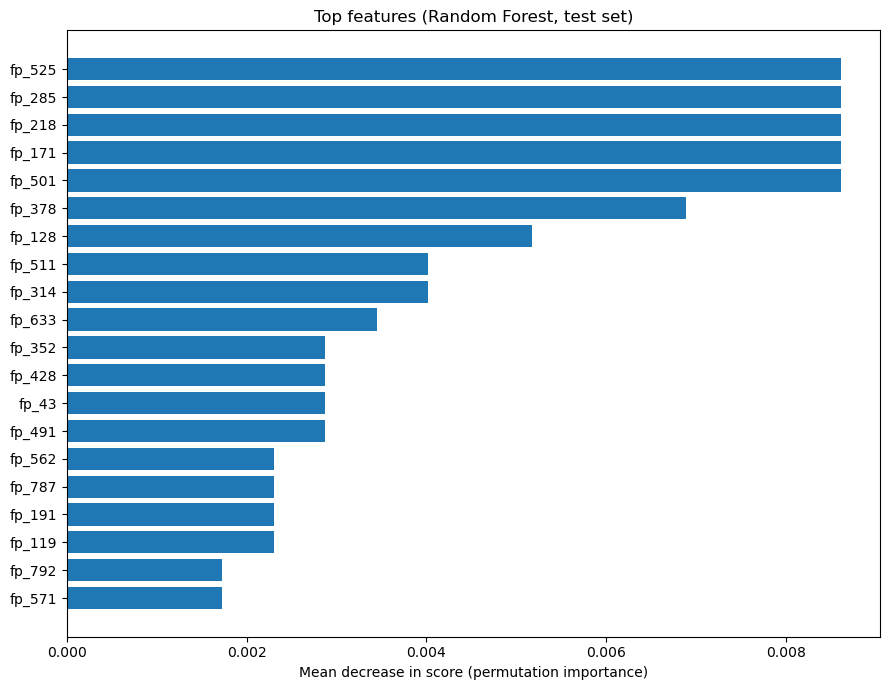

In [53]:
# STEP 10 — Model interpretability (Permutation Feature Importance, leak-safe)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GroupShuffleSplit

# 1) Load PCM dataset
df = pd.read_csv("step6_pcm_dataset.csv")

# 2) Select ONLY numeric features used in modeling
fp_cols  = [c for c in df.columns if c.startswith("fp_")]
aac_cols = [c for c in df.columns if c.startswith("AAC_")]
feature_cols = fp_cols + aac_cols
if not feature_cols:
    raise ValueError("No features found. Expected columns starting with 'fp_' and 'AAC_'.")

X_all = df[feature_cols].astype(np.float32)
y_all = df["label"].astype(int)
groups_all = df["molecule_chembl_id"].astype(str)

# 3) Reuse the exact train/test split from Step 7 (or create one if missing)
try:
    tr_idx = pd.read_csv("indices_train.csv", header=None)[0].values
    te_idx = pd.read_csv("indices_test.csv",  header=None)[0].values
    print("Loaded Step 7 train/test indices.")
except Exception:
    print("indices_train/test.csv not found; creating a new group-wise split like Step 7.")
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, te_idx = next(gss.split(X_all.values, y_all.values, groups_all.values))
    pd.Series(tr_idx).to_csv("indices_train.csv", index=False, header=False)
    pd.Series(te_idx).to_csv("indices_test.csv",  index=False, header=False)

Xtr, Xte = X_all.iloc[tr_idx], X_all.iloc[te_idx]
ytr, yte = y_all.iloc[tr_idx], y_all.iloc[te_idx]

print(f"Train: {Xtr.shape}, Test: {Xte.shape}")

# 4) Fit Random Forest on TRAIN only (match Step 7 settings as much as possible)
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=1,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
)
rf.fit(Xtr, ytr)

# 5) Permutation importance on TEST only (no leakage)
perm = permutation_importance(
    rf, Xte, yte,
    n_repeats=15,
    random_state=42,
    n_jobs=-1
)

imp_df = pd.DataFrame({
    "feature": Xte.columns,
    "importance_mean": perm.importances_mean,
    "importance_std":  perm.importances_std
}).sort_values("importance_mean", ascending=False)

# Save full table (optional for poster/report)
imp_df.to_csv("step10_feature_importance.csv", index=False)

# 6) Show top 20 features
top_n = 20
print("\nTop 20 features by permutation importance (TEST set):")
print(imp_df.head(top_n))

plt.figure(figsize=(9, 7))
plt.barh(imp_df.head(top_n)["feature"], imp_df.head(top_n)["importance_mean"])
plt.gca().invert_yaxis()
plt.xlabel("Mean decrease in score (permutation importance)")
plt.title("Top features (Random Forest, test set)")
plt.tight_layout()
plt.show()



Loaded Step 7 train/test indices.


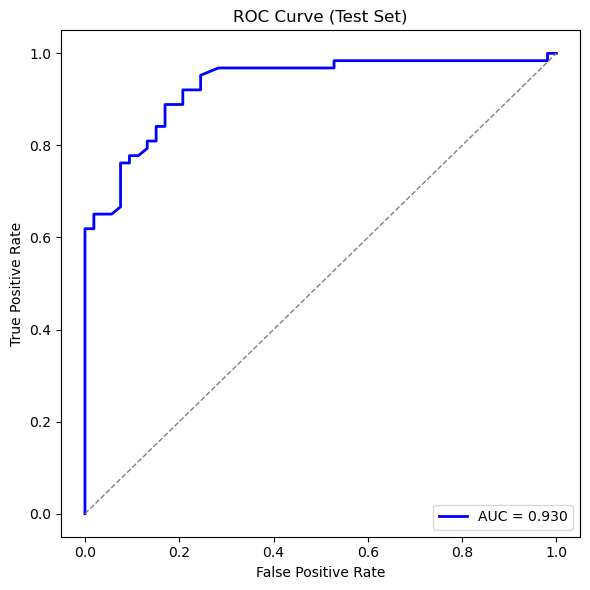

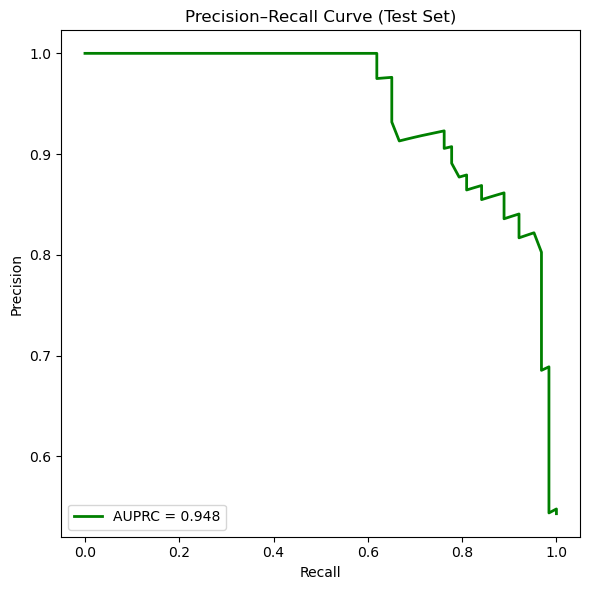

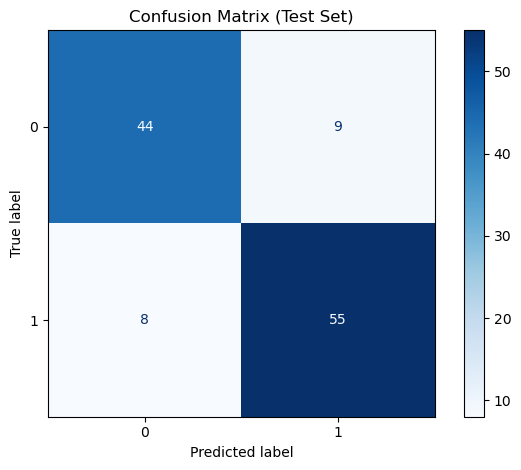

              precision    recall  f1-score     support
0              0.846154  0.830189  0.838095   53.000000
1              0.859375  0.873016  0.866142   63.000000
accuracy       0.853448  0.853448  0.853448    0.853448
macro avg      0.852764  0.851602  0.852118  116.000000
weighted avg   0.853334  0.853448  0.853327  116.000000

ROC AUC: 0.930
Average Precision (AUPRC): 0.948


In [54]:
# STEP 11 — Final evaluation & plots for poster/report

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.model_selection import GroupShuffleSplit

# 1) Load dataset and features
df = pd.read_csv("step6_pcm_dataset.csv")
fp_cols  = [c for c in df.columns if c.startswith("fp_")]
aac_cols = [c for c in df.columns if c.startswith("AAC_")]
feature_cols = fp_cols + aac_cols
if not feature_cols:
    raise ValueError("No fp_/AAC_ columns found.")

X_all = df[feature_cols].astype(np.float32)
y_all = df["label"].astype(int)
groups_all = df["molecule_chembl_id"].astype(str)

# 2) Load the same train/test indices from Step 7
try:
    tr_idx = pd.read_csv("indices_train.csv", header=None)[0].values
    te_idx = pd.read_csv("indices_test.csv",  header=None)[0].values
    print("Loaded Step 7 train/test indices.")
except Exception:
    print("Train/test indices not found; recreating (grouped split).")
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_idx, te_idx = next(gss.split(X_all.values, y_all.values, groups_all.values))
    pd.Series(tr_idx).to_csv("indices_train.csv", index=False, header=False)
    pd.Series(te_idx).to_csv("indices_test.csv",  index=False, header=False)

Xtr, Xte = X_all.iloc[tr_idx], X_all.iloc[te_idx]
ytr, yte = y_all.iloc[tr_idx], y_all.iloc[te_idx]

# 3) Train the final Random Forest model (same settings as Step 7)
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=1,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(Xtr, ytr)

# 4) Predictions and probabilities
y_prob = rf.predict_proba(Xte)[:, 1]
y_pred = rf.predict(Xte)

# 5) ROC curve
fpr, tpr, _ = roc_curve(yte, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("step11_ROC_curve.png", dpi=300)
plt.show()

# 6) Precision–Recall curve
prec, rec, _ = precision_recall_curve(yte, y_prob)
ap_score = average_precision_score(yte, y_prob)

plt.figure(figsize=(6, 6))
plt.plot(rec, prec, color="green", lw=2, label=f"AUPRC = {ap_score:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig("step11_PR_curve.png", dpi=300)
plt.show()

# 7) Confusion matrix
cm = confusion_matrix(yte, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.savefig("step11_confusion_matrix.png", dpi=300)
plt.show()

# 8) Metrics table
report = classification_report(yte, y_pred, output_dict=True)
metrics_df = pd.DataFrame(report).transpose()
metrics_df.to_csv("step11_metrics_table.csv")
print(metrics_df)

print(f"\nROC AUC: {roc_auc:.3f}")
print(f"Average Precision (AUPRC): {ap_score:.3f}")
